# SDSU Data

This Jupyter notebook uses Python and SQLite to take an excel file of a list of Mechanical Engineering classes at SDSU, and creates an SQL database which has separate tables for each instance of Class, Location, and Time, and links them all together in an overall Schedule table. The database is then queried with various requests.

The excel file is in the Github repository. Data source: https://sunspot.sdsu.edu/schedule/search?mode=search&abbrev=M%20E

In [1]:
import numpy as np
import pandas as pd
import sqlite3

First, read the excel file into the Pandas DataFrame.

In [2]:
df = pd.read_excel(io='SDSU_mech_eng_classes.xlsx', header=1)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Department      96 non-null     object 
 1   Subject         96 non-null     object 
 2   Course #        96 non-null     int64  
 3   Suffix          13 non-null     object 
 4   Catalog #       0 non-null      float64
 5   Title           96 non-null     object 
 6   Section         96 non-null     int64  
 7   Schedule #      96 non-null     object 
 8   Units           96 non-null     int64  
 9   Session         96 non-null     object 
 10  Seats           96 non-null     int64  
 11  Available       96 non-null     int64  
 12  Total Enrolled  96 non-null     int64  
 13  Blocked         0 non-null      float64
 14  Footnotes       89 non-null     object 
 15  SDSU Enrolled   0 non-null      float64
 16  EE Enrolled     0 non-null      float64
 17  SDSU Audit      0 non-null      float

In [4]:
df = df.drop(['Catalog #', 'Blocked', 'SDSU Enrolled', 'EE Enrolled', 'SDSU Audit', 'EE Audit'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Department      96 non-null     object 
 1   Subject         96 non-null     object 
 2   Course #        96 non-null     int64  
 3   Suffix          13 non-null     object 
 4   Title           96 non-null     object 
 5   Section         96 non-null     int64  
 6   Schedule #      96 non-null     object 
 7   Units           96 non-null     int64  
 8   Session         96 non-null     object 
 9   Seats           96 non-null     int64  
 10  Available       96 non-null     int64  
 11  Total Enrolled  96 non-null     int64  
 12  Footnotes       89 non-null     object 
 13  Meeting Type    96 non-null     object 
 14  Building        84 non-null     object 
 15  Room            84 non-null     float64
 16  Start Time      84 non-null     float64
 17  End Time        84 non-null     float

Using this DataFrame, we can make a SQL relational database as shown in the below image (created with Lucidchart). There are separate tables for each specific Class, Location, and Time, and a connector table called Schedule to combine all instances.

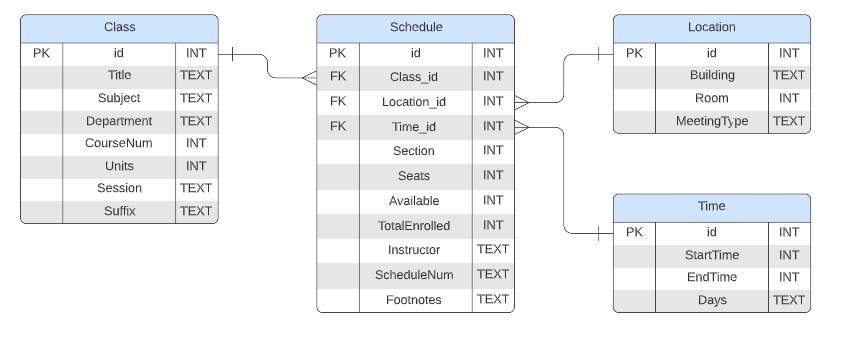

Connecting Python to SQLite.

In [5]:
sqlite3.register_adapter(np.int64, lambda val: int(val))
con = sqlite3.connect("SDSU_mech_eng_classes.sqlite")
cur = con.cursor()

Creating each of the tables by passing SQL to the SQLite browser.

In [6]:
cur.execute('DROP TABLE IF EXISTS Class')
cur.execute('DROP TABLE IF EXISTS Location')
cur.execute('DROP TABLE IF EXISTS Time')
cur.execute('DROP TABLE IF EXISTS Schedule')

cur.execute('''CREATE TABLE Class (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, Title TEXT, Subject TEXT, Department TEXT, 
                                  CourseNum INTEGER, Units INTEGER, Session TEXT, Suffix TEXT)''')
cur.execute('''CREATE TABLE Location (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, Building TEXT, Room INTEGER, 
                                      MeetingType TEXT)''')
cur.execute('''CREATE TABLE Time (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, StartTime INTEGER, 
                                  EndTime INTEGER, Days TEXT)''')
cur.execute('''CREATE TABLE Schedule (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, Class_id INTEGER, Location_id INTEGER, 
                                      Time_id INTEGER, Section INTEGER, Seats INTEGER, Available INTEGER, TotalEnrolled INTEGER, 
                                     Instructor TEXT, ScheduleNum TEXT, Footnotes TEXT)''')


Next, we step through each row of the Pandas DataFrame and add the info to the SQLite tables. For the Class, Time, and Location tables, if the specific instance already exists, it does not get added again. The Schedule connector table is created using the foreign keys of the Class, Time, and Location tables.

In [7]:
for i in range(len(df)):
    
    # Pulls the data from the columns for the Class table
    tup =  tuple(df[['Title','Subject','Department','Course #','Units','Session','Suffix']].iloc[i].to_list())
    cur.execute('''SELECT id FROM Class WHERE Title=? AND Subject=? AND Department=? AND CourseNum=? AND Units=? AND 
                                              Session=? AND (Suffix=? OR SUFFIX IS NULL)''', tup) 
    # If a Class comes back with the SELECT, we grab its index (id) number for use when we populate the Schedule table.
    # If it comes back as None, then we add the new Class.
    Class_id = cur.fetchone()
    if Class_id is not None:
        Class_id = Class_id[0]
    else:
        cur.execute('''INSERT INTO Class (Title, Subject, Department, CourseNum, Units, Session, Suffix)
                       VALUES (?,?,?,?,?,?,?)''', tup)
        con.commit()
        cur.execute('''SELECT id FROM Class WHERE Title=? AND Subject=? AND Department=? AND CourseNum=? AND Units=? AND 
                                                   Session=? AND (Suffix=? OR SUFFIX IS NULL)''', tup) 
        Class_id = cur.fetchone()[0]

    
    # This does the same thing, but for the Location table
    tup =  tuple(df[['Building','Room','Meeting Type']].iloc[i].to_list())
    cur.execute('''SELECT id FROM Location WHERE (Building=? OR Building IS NULL) AND (Room=? OR Room IS NULL) AND 
                                                   MeetingType=?''', tup) 
    Location_id = cur.fetchone()
    if Location_id is not None:
        Location_id = Location_id[0]
    else:
        cur.execute('''INSERT INTO Location (Building, Room, MeetingType) VALUES (?,?,?)''', tup)
        con.commit()
        cur.execute('''SELECT id FROM Location WHERE (Building=? OR Building IS NULL) AND (Room=? OR Room IS NULL) AND 
                                                    MeetingType=?''', tup) 
        Location_id = cur.fetchone()[0]
    
    # This does the same thing, but for the Time table
    tup =  tuple(df[['Start Time','End Time','Days']].iloc[i].to_list())
    cur.execute('''SELECT id FROM Time WHERE (StartTime=? OR StartTime IS NULL) AND 
                                             (EndTime=? OR EndTime IS NULL) AND Days=?''', tup) 
    Time_id = cur.fetchone()
    if Time_id is not None:
        Time_id = Time_id[0]
    else:
        cur.execute('''INSERT INTO Time (StartTime, EndTime, Days) VALUES (?,?,?)''', tup)
        con.commit()
        cur.execute('''SELECT id FROM Time WHERE (StartTime=? OR StartTime IS NULL) AND 
                                                (EndTime=? OR EndTime IS NULL) AND Days=?''', tup) 
        Time_id = cur.fetchone()[0]
        
        
    # Now we fill in the Schedule table, using the foreign keys we just gathered for Class_id, Location_id, and Time_id
    foreign_keys = [Class_id, Location_id, Time_id]
    schedule_data = df[['Section','Seats','Available','Total Enrolled','Instructor','Schedule #','Footnotes']].iloc[i].to_list()
    foreign_keys.extend(schedule_data)
    tup = tuple(foreign_keys)
    cur.execute('''INSERT INTO Schedule (Class_id, Location_id, Time_id, Section, Seats, Available, TotalEnrolled, Instructor, 
                                         ScheduleNum, Footnotes) VALUES (?,?,?,?,?,?,?,?,?,?)''', tup)
    con.commit()        
        
        
        

Now we can query the database for any type of search using the JOIN keyword.
Here we search for all the options for the class "MECH & THERMAL SYS LAB".
We can see that the last two classes are fully filled up with 0 seats remaining, since the "Available" column is 0.

In [8]:
cur.execute('''SELECT Class.Title, Location.Building, Time.StartTime, Time.Days, Schedule.Instructor, Schedule.Available
            FROM Schedule JOIN Class JOIN Location JOIN Time 
            ON Class_id = Class.id AND Location_id = Location.id AND Time_id = Time.id
            WHERE Class.Title = ?''', ('MECH & THERMAL SYS LAB',))
cur.fetchall()

[('MECH & THERMAL SYS LAB', 'EIS', 1000, 'M', 'H. NOURALLAHI', 3),
 ('MECH & THERMAL SYS LAB', 'EIS', 1100, 'M', 'H. NOURALLAHI', 3),
 ('MECH & THERMAL SYS LAB', 'EIS', 1000, 'W', 'H. NOURALLAHI', 0),
 ('MECH & THERMAL SYS LAB', 'EIS', 1100, 'W', 'H. NOURALLAHI', 0)]

Lets count and see how many classes are fully filled up with 0 seats remaining, and how many classes are still available.

In [9]:
cur.execute('SELECT COUNT(*) FROM Schedule WHERE Available <= 0')
x = cur.fetchall()
print('There are ' + str(x[0][0]) + ' classes that are fully filled.')
cur.execute('SELECT COUNT(*) FROM Schedule WHERE Available > 0')
x = cur.fetchall()
print('There are ' + str(x[0][0]) + ' classes that are still available.')

There are 27 classes that are fully filled.
There are 69 classes that are still available.


Lets remove all of the classes that are fully filled since we can't enroll in them.

In [10]:
cur.execute('DELETE FROM Schedule WHERE Available <= 0')
con.commit()

Now we can do the original query for class "MECH & THERMAL SYS LAB", and see that only 2 show up now.

In [11]:
cur.execute('''SELECT Class.Title, Location.Building, Time.StartTime, Time.Days, Schedule.Instructor, Schedule.Available
            FROM Schedule JOIN Class JOIN Location JOIN Time 
            ON Class_id = Class.id AND Location_id = Location.id AND Time_id = Time.id
            WHERE Class.Title = ?''', ('MECH & THERMAL SYS LAB',))
cur.fetchall()

[('MECH & THERMAL SYS LAB', 'EIS', 1000, 'M', 'H. NOURALLAHI', 3),
 ('MECH & THERMAL SYS LAB', 'EIS', 1100, 'M', 'H. NOURALLAHI', 3)]

Lets say you want your early class (9AM or earlier) to be at building E, which is closest to you.

In [12]:
cur.execute('''SELECT Class.Title, Time.StartTime, Location.Building
            FROM Schedule JOIN Class JOIN Location JOIN Time 
            ON Class_id = Class.id AND Location_id = Location.id AND Time_id = Time.id
            WHERE StartTime <= 900 AND Building = ?''', ('E',))
cur.fetchall()

[('COMPUTER-AIDED DESIGN', 800, 'E'),
 ('COMPUTER-AIDED DESIGN', 900, 'E'),
 ('COMPUTER-AIDED DESIGN', 800, 'E'),
 ('COMPUTER-AIDED DESIGN', 800, 'E'),
 ('COMPUTER-AIDED DESIGN', 900, 'E'),
 ('MECHATRONICS LABORATORY', 800, 'E'),
 ('ENRGY& THRM SYS ANAL/DSGN', 800, 'E'),
 ('FUNDAMENTALS OF NANOBIO', 800, 'E')]

Or if you want to see all the classes that your favorite teacher C. SAGHAFI is teaching that aren't on Fridays.

In [13]:
cur.execute('''SELECT Class.Title, Schedule.Instructor, Time.Days
            FROM Schedule JOIN Class JOIN Location JOIN Time 
            ON Class_id = Class.id AND Location_id = Location.id AND Time_id = Time.id
            WHERE Instructor = ? AND Days != ?''', ('C. SAGHAFI','F'))
cur.fetchall()

[('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'M'),
 ('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'M'),
 ('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'W'),
 ('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'W'),
 ('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'M'),
 ('COMPUTER-AIDED DESIGN', 'C. SAGHAFI', 'M')]

In [14]:
con.close()